## Preparing notebook

In [1]:
! pip install hazm
! pip install arabic_reshaper
! pip install keras --upgrade
! pip install tensorflow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.8.2 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
a

## Import requirement libraries

In [2]:
# Preprocessing
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from hazm import Normalizer, Lemmatizer, Stemmer, stopwords_list, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from progressbar import ProgressBar
# ML
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
# Visualization
from bidi.algorithm import get_display
import arabic_reshaper
from arabic_reshaper import reshape
import matplotlib.pyplot as plt

## Load data

In [3]:
datas = pd.read_csv('/kaggle/input/persion-news-dataset/per.csv')
datas.drop(['NewsID', 'Date', 'Time', 'Category'], axis=1, inplace=True)
datas.head()

,Title,Body,Category2
0,\nوزير علوم درجمع استادان نمونه: سن بازنشستگي ...,\nوزير علوم در جمع استادان نمونه كشور گفت: از ...,\nآموزشي
1,\nگردهمايي دانش‌آموختگان موسسه آموزش عالي سوره...,\nبه گزارش سرويس صنفي آموزشي خبرگزاري دانشجويا...,\nآموزشي
2,\nنتايج آزمون دوره‌هاي فراگير دانشگاه پيام‌نور...,\nنتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و...,\nآموزشي
3,\nهمايش يكروزه آسيب شناسي مفهوم روابط عمومي در...,\n,\nاجتماعي
4,\nوضعيت اقتصادي و ميزان تحصيلات والدين از مهمت...,\nمحمدتقي علوي يزدي، مجري اين طرح پژوهشي در اي...,\nآموزشي


## Preprocessing

In [4]:
normalizer = Normalizer()
stop_words_lsit = stopwords_list()
punctuation_lsit = list(punctuation)
punctuation_lsit.extend(['»', '«', '؛' ,'،' ,'؟'])
stemmer = Stemmer()
lemmetizer = Lemmatizer()

In [5]:
p = ProgressBar(max_value=len(datas)).start()
dataset = pd.DataFrame(columns=['Text', 'Label'])
for i, row in datas.iterrows():
    text = row['Title'] + ' ' + row['Body']
    text_normal = normalizer.normalize(text)
    text_normal_tokenized = word_tokenize(text_normal)
    text_normal_tokenized_filtered = [w for w in text_normal_tokenized if w not in stop_words_lsit and w not in punctuation_lsit]
    text_normal_tokenized_filtered_stem = [stemmer.stem(w) for w in text_normal_tokenized_filtered]
    text_normal_tokenized_filtered_lem = [lemmetizer.lemmatize(w).replace('#', ' ') for w in text_normal_tokenized_filtered]
    dataset.loc[i]={
        'Text':' '.join(text_normal_tokenized_filtered_stem) + ' ' + ' '.join(text_normal_tokenized_filtered_lem),
        'Label':row['Category2'].replace('\n', '').strip(),
    }
    p.update(i + 1)
p.finish()

100% (10999 of 10999) |##################| Elapsed Time: 0:02:27 Time:  0:02:27


In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset['Text'], dataset['Label'], test_size=0.33, random_state=42)

In [7]:
tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train = tfidfvectorizer.fit_transform(X_train)
X_test = tfidfvectorizer.transform(X_test)

In [8]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

In [9]:
labels = [get_display(reshape(x)) for x in list(labelencoder.classes_)]

## ML

### Decision tree (defualt parameters)

In [10]:
DT_cl = DecisionTreeClassifier()
DT_cl.fit(X_train, y_train)

DecisionTreeClassifier()

In [11]:
y_train_pred = DT_cl.predict(X_train)
print('Decision tree result on train data\n', classification_report(y_pred=y_train_pred, y_true=y_train))

Decision tree result on train data
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00       661
           2       1.00      1.00      1.00       675
           3       1.00      1.00      1.00       661
           4       1.00      1.00      1.00       656
           5       1.00      1.00      1.00       681
           6       1.00      1.00      1.00       672
           7       1.00      1.00      1.00       684
           8       1.00      1.00      1.00       656
           9       1.00      1.00      1.00       672
          10       1.00      1.00      1.00       680

    accuracy                           1.00      7369
   macro avg       1.00      1.00      1.00      7369
weighted avg       1.00      1.00      1.00      7369



In [12]:
y_test_pred = DT_cl.predict(X_test)
print('Decision tree result on test data\n', classification_report(y_pred=y_test_pred, y_true=y_test))

Decision tree result on test data
               precision    recall  f1-score   support

           0       0.83      0.84      0.83       329
           1       0.43      0.38      0.41       339
           2       0.57      0.59      0.58       325
           3       0.82      0.87      0.84       339
           4       0.73      0.78      0.75       343
           5       0.51      0.55      0.53       319
           6       0.65      0.69      0.67       328
           7       0.66      0.60      0.63       316
           8       0.75      0.68      0.71       344
           9       0.81      0.75      0.78       328
          10       0.85      0.90      0.87       320

    accuracy                           0.69      3630
   macro avg       0.69      0.69      0.69      3630
weighted avg       0.69      0.69      0.69      3630



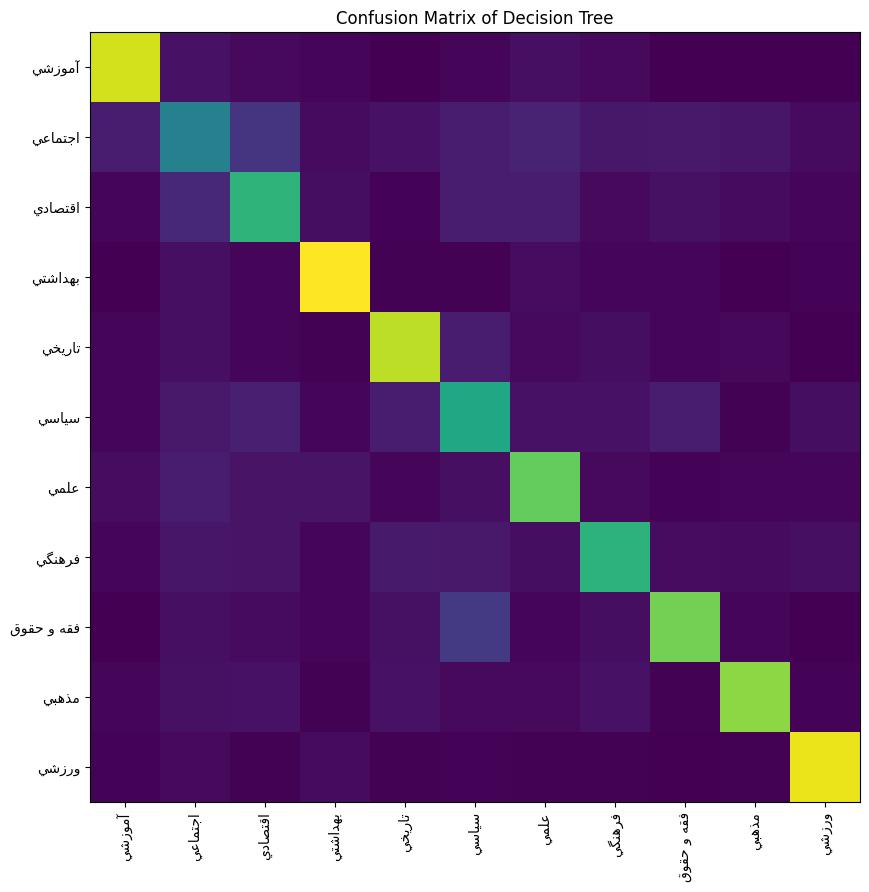

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_pred=y_test_pred, y_true=y_test))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rotation=90, labels=labels)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=labels)
plt.title('Confusion Matrix of Decision Tree')
plt.show();

### SVM (defualt parameters)

In [14]:
SVM_cl = SVC()
SVM_cl.fit(X_train, y_train)

SVC()

In [15]:
y_train_pred = SVM_cl.predict(X_train)
print('SVM result on train data\n', classification_report(y_pred=y_train_pred, y_true=y_train))

SVM result on train data
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       671
           1       1.00      0.99      0.99       661
           2       1.00      1.00      1.00       675
           3       0.99      1.00      0.99       661
           4       1.00      1.00      1.00       656
           5       1.00      0.98      0.99       681
           6       1.00      0.99      0.99       672
           7       1.00      1.00      1.00       684
           8       0.99      1.00      1.00       656
           9       1.00      1.00      1.00       672
          10       0.99      1.00      1.00       680

    accuracy                           1.00      7369
   macro avg       1.00      1.00      1.00      7369
weighted avg       1.00      1.00      1.00      7369



In [16]:
y_test_pred = SVM_cl.predict(X_test)
print('SVM result on test data\n', classification_report(y_pred=y_test_pred, y_true=y_test))

SVM result on test data
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       329
           1       0.67      0.62      0.65       339
           2       0.80      0.80      0.80       325
           3       0.86      0.94      0.90       339
           4       0.89      0.92      0.91       343
           5       0.77      0.72      0.75       319
           6       0.86      0.77      0.81       328
           7       0.83      0.87      0.85       316
           8       0.87      0.87      0.87       344
           9       0.97      0.93      0.95       328
          10       0.97      0.96      0.97       320

    accuracy                           0.85      3630
   macro avg       0.85      0.85      0.85      3630
weighted avg       0.85      0.85      0.85      3630



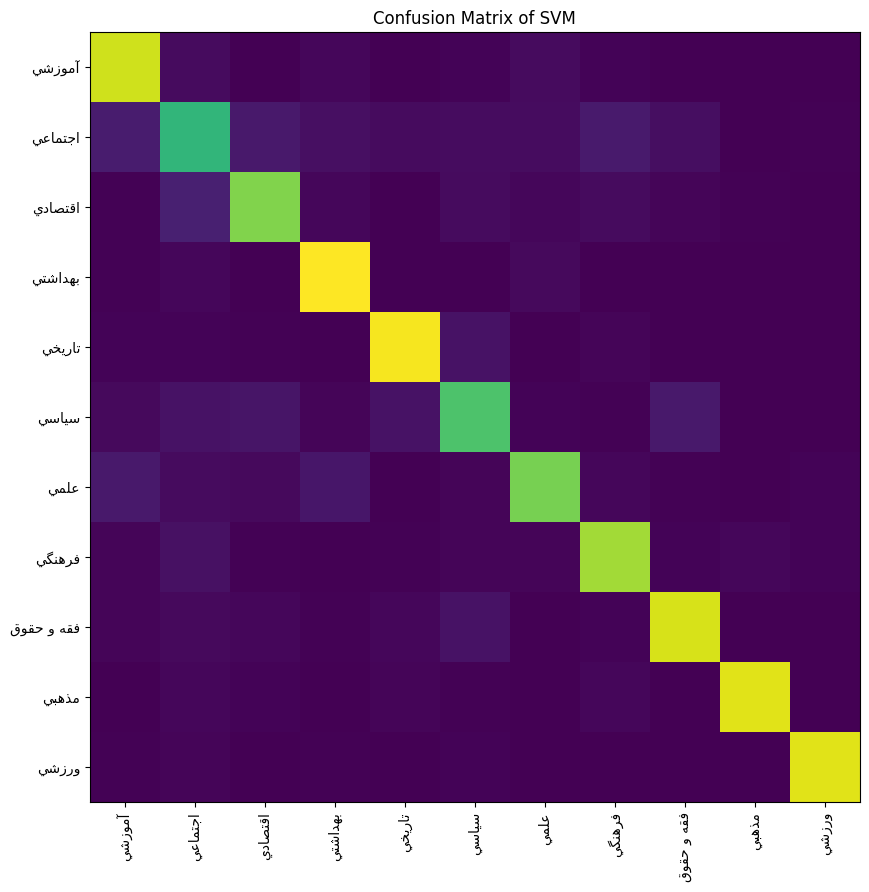

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_pred=y_test_pred, y_true=y_test))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rotation=90, labels=labels)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=labels)
plt.title('Confusion Matrix of SVM')
plt.show();

### Random forest (defualt parameters)

In [18]:
RF_cl = RandomForestClassifier()
RF_cl.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
y_train_pred = RF_cl.predict(X_train)
print('Random forest result on train data\n', classification_report(y_pred=y_train_pred, y_true=y_train))

Random forest result on train data
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       1.00      1.00      1.00       661
           2       1.00      1.00      1.00       675
           3       1.00      1.00      1.00       661
           4       1.00      1.00      1.00       656
           5       1.00      1.00      1.00       681
           6       1.00      1.00      1.00       672
           7       1.00      1.00      1.00       684
           8       1.00      1.00      1.00       656
           9       1.00      1.00      1.00       672
          10       1.00      1.00      1.00       680

    accuracy                           1.00      7369
   macro avg       1.00      1.00      1.00      7369
weighted avg       1.00      1.00      1.00      7369



In [20]:
y_test_pred = RF_cl.predict(X_test)
print('Random forest result on test data\n', classification_report(y_pred=y_test_pred, y_true=y_test))

Random forest result on test data
               precision    recall  f1-score   support

           0       0.79      0.95      0.86       329
           1       0.76      0.37      0.50       339
           2       0.75      0.81      0.78       325
           3       0.84      0.98      0.90       339
           4       0.82      0.86      0.84       343
           5       0.74      0.73      0.73       319
           6       0.85      0.78      0.81       328
           7       0.80      0.84      0.82       316
           8       0.86      0.88      0.87       344
           9       0.90      0.91      0.91       328
          10       0.95      0.96      0.95       320

    accuracy                           0.82      3630
   macro avg       0.82      0.83      0.82      3630
weighted avg       0.82      0.82      0.82      3630



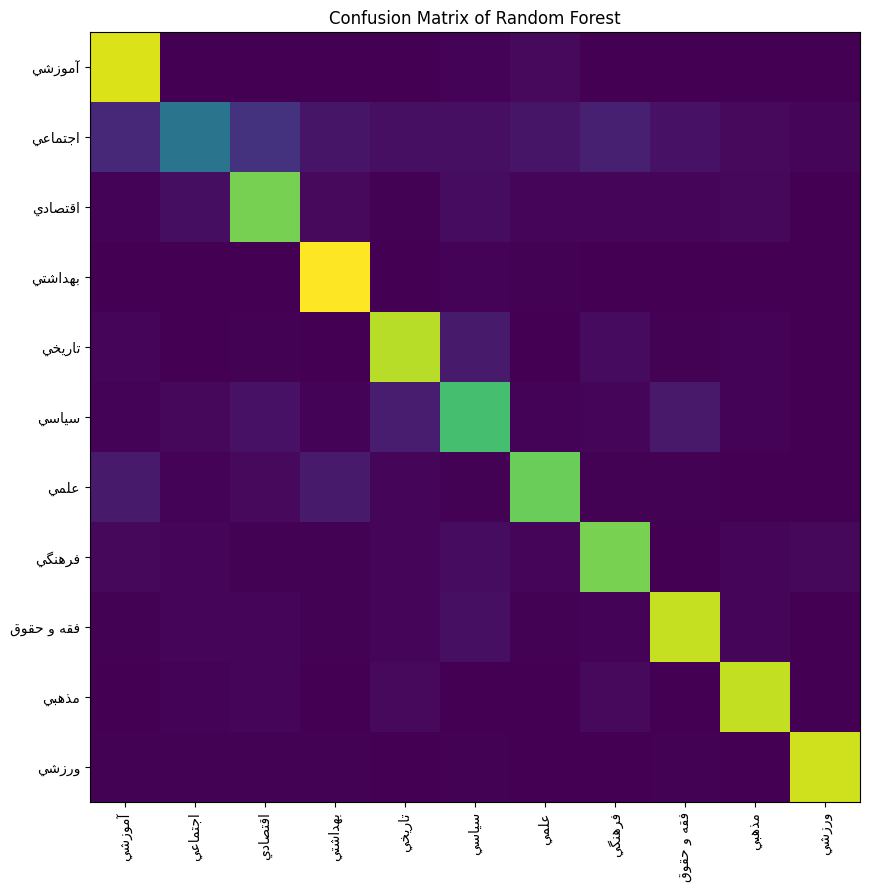

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_pred=y_test_pred, y_true=y_test))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rotation=90, labels=labels)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=labels)
plt.title('Confusion Matrix of Random Forest')
plt.show();

### Voting classifier

In [22]:
clf_1 = SVC() 
clf_2 = RandomForestClassifier()
VO_cl = VotingClassifier(
    estimators=[('svc', clf_1), ('rnadom_forest', clf_2)],
    voting='hard', verbose=True)
VO_cl.fit(X_train, y_train)

[Voting] ...................... (1 of 2) Processing svc, total= 4.9min
[Voting] ............ (2 of 2) Processing rnadom_forest, total= 3.3min


VotingClassifier(estimators=[('svc', SVC()),
                             ('rnadom_forest', RandomForestClassifier())],
                 verbose=True)

In [23]:
y_train_pred = VO_cl.predict(X_train)
print('Voting classifier result on train data\n', classification_report(y_pred=y_train_pred, y_true=y_train))

Voting classifier result on train data
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       671
           1       1.00      1.00      1.00       661
           2       1.00      1.00      1.00       675
           3       0.99      1.00      0.99       661
           4       1.00      1.00      1.00       656
           5       1.00      0.99      1.00       681
           6       1.00      0.99      0.99       672
           7       1.00      1.00      1.00       684
           8       1.00      1.00      1.00       656
           9       1.00      1.00      1.00       672
          10       1.00      1.00      1.00       680

    accuracy                           1.00      7369
   macro avg       1.00      1.00      1.00      7369
weighted avg       1.00      1.00      1.00      7369



In [24]:
y_test_pred = VO_cl.predict(X_test)
print('Voting classifier result on test data\n', classification_report(y_pred=y_test_pred, y_true=y_test))

Voting classifier result on test data
               precision    recall  f1-score   support

           0       0.75      0.98      0.85       329
           1       0.65      0.60      0.63       339
           2       0.78      0.83      0.81       325
           3       0.86      0.96      0.90       339
           4       0.81      0.93      0.87       343
           5       0.78      0.69      0.73       319
           6       0.90      0.75      0.82       328
           7       0.86      0.82      0.84       316
           8       0.91      0.83      0.87       344
           9       0.98      0.88      0.93       328
          10       0.99      0.95      0.97       320

    accuracy                           0.84      3630
   macro avg       0.84      0.84      0.84      3630
weighted avg       0.84      0.84      0.84      3630



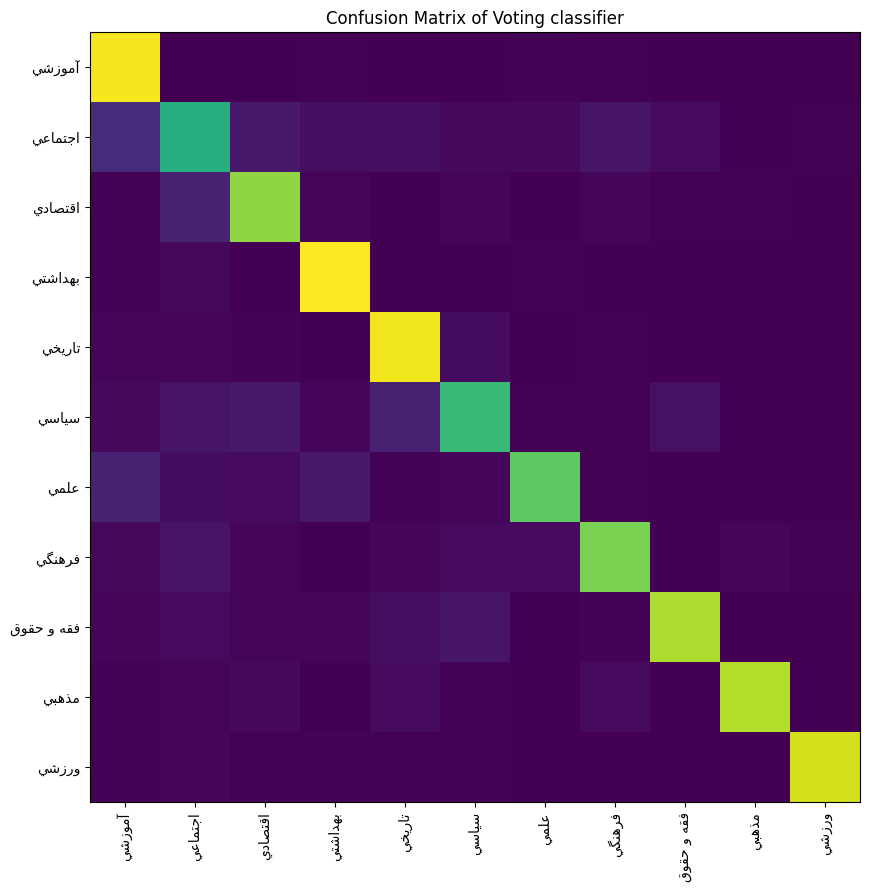

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_pred=y_test_pred, y_true=y_test))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rotation=90, labels=labels)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=labels)
plt.title('Confusion Matrix of Voting classifier')
plt.show();